In [42]:
import matplotlib.pyplot as plt


def roc_plot(y_test, y_pred):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from itertools import cycle

    hand_name = {
        0: 'Nothing in hand',
        1: 'One pair',
        2: 'Two pairs',
        3: 'Three of a kind',
        4: 'Straight',
        5: 'Flush',
        6: 'Full house',
        7: 'Four of a kind',
        8: 'Straight flush',
        9: 'Royal flush',
    }

    y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    n_classes = y_test.shape[1]

    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['red', 'purple', 'green', 'orange', 'blue',
                   'brown', 'pink', 'gray', 'olive', 'cyan'])
    plt.figure(figsize=(20, 20))
    for i, color in zip(range(n_classes), colors):
        plt.subplot(4, 3, i + 1)
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{i}. {hand_name[i]} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([-.05, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Poker Hands ROC')
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show(block=True)

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cols = ["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "CLASS"]

df = pd.read_csv('./data/poker-hand-testing.data', names=cols)

x = (df.iloc[:, :10].values)
y = df['CLASS'].values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.2, stratify=y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=.25, stratify=y_train, random_state=42)

In [44]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

cat_model = CatBoostClassifier(random_state=42, learning_rate=0.0075, iterations=10000,
                               loss_function='MultiClass', task_type='GPU', verbose=200)
cat_model.fit(x_train, y_train, eval_set=(x_val, y_val), early_stopping_rounds=50)
print(cat_model.get_feature_importance())

y_pred = cat_model.predict(x_test)
y_prob = cat_model.predict_proba(x_test)

0:	learn: 2.2763167	test: 2.2763255	best: 2.2763255 (0)	total: 33.4ms	remaining: 5m 34s


KeyboardInterrupt: 

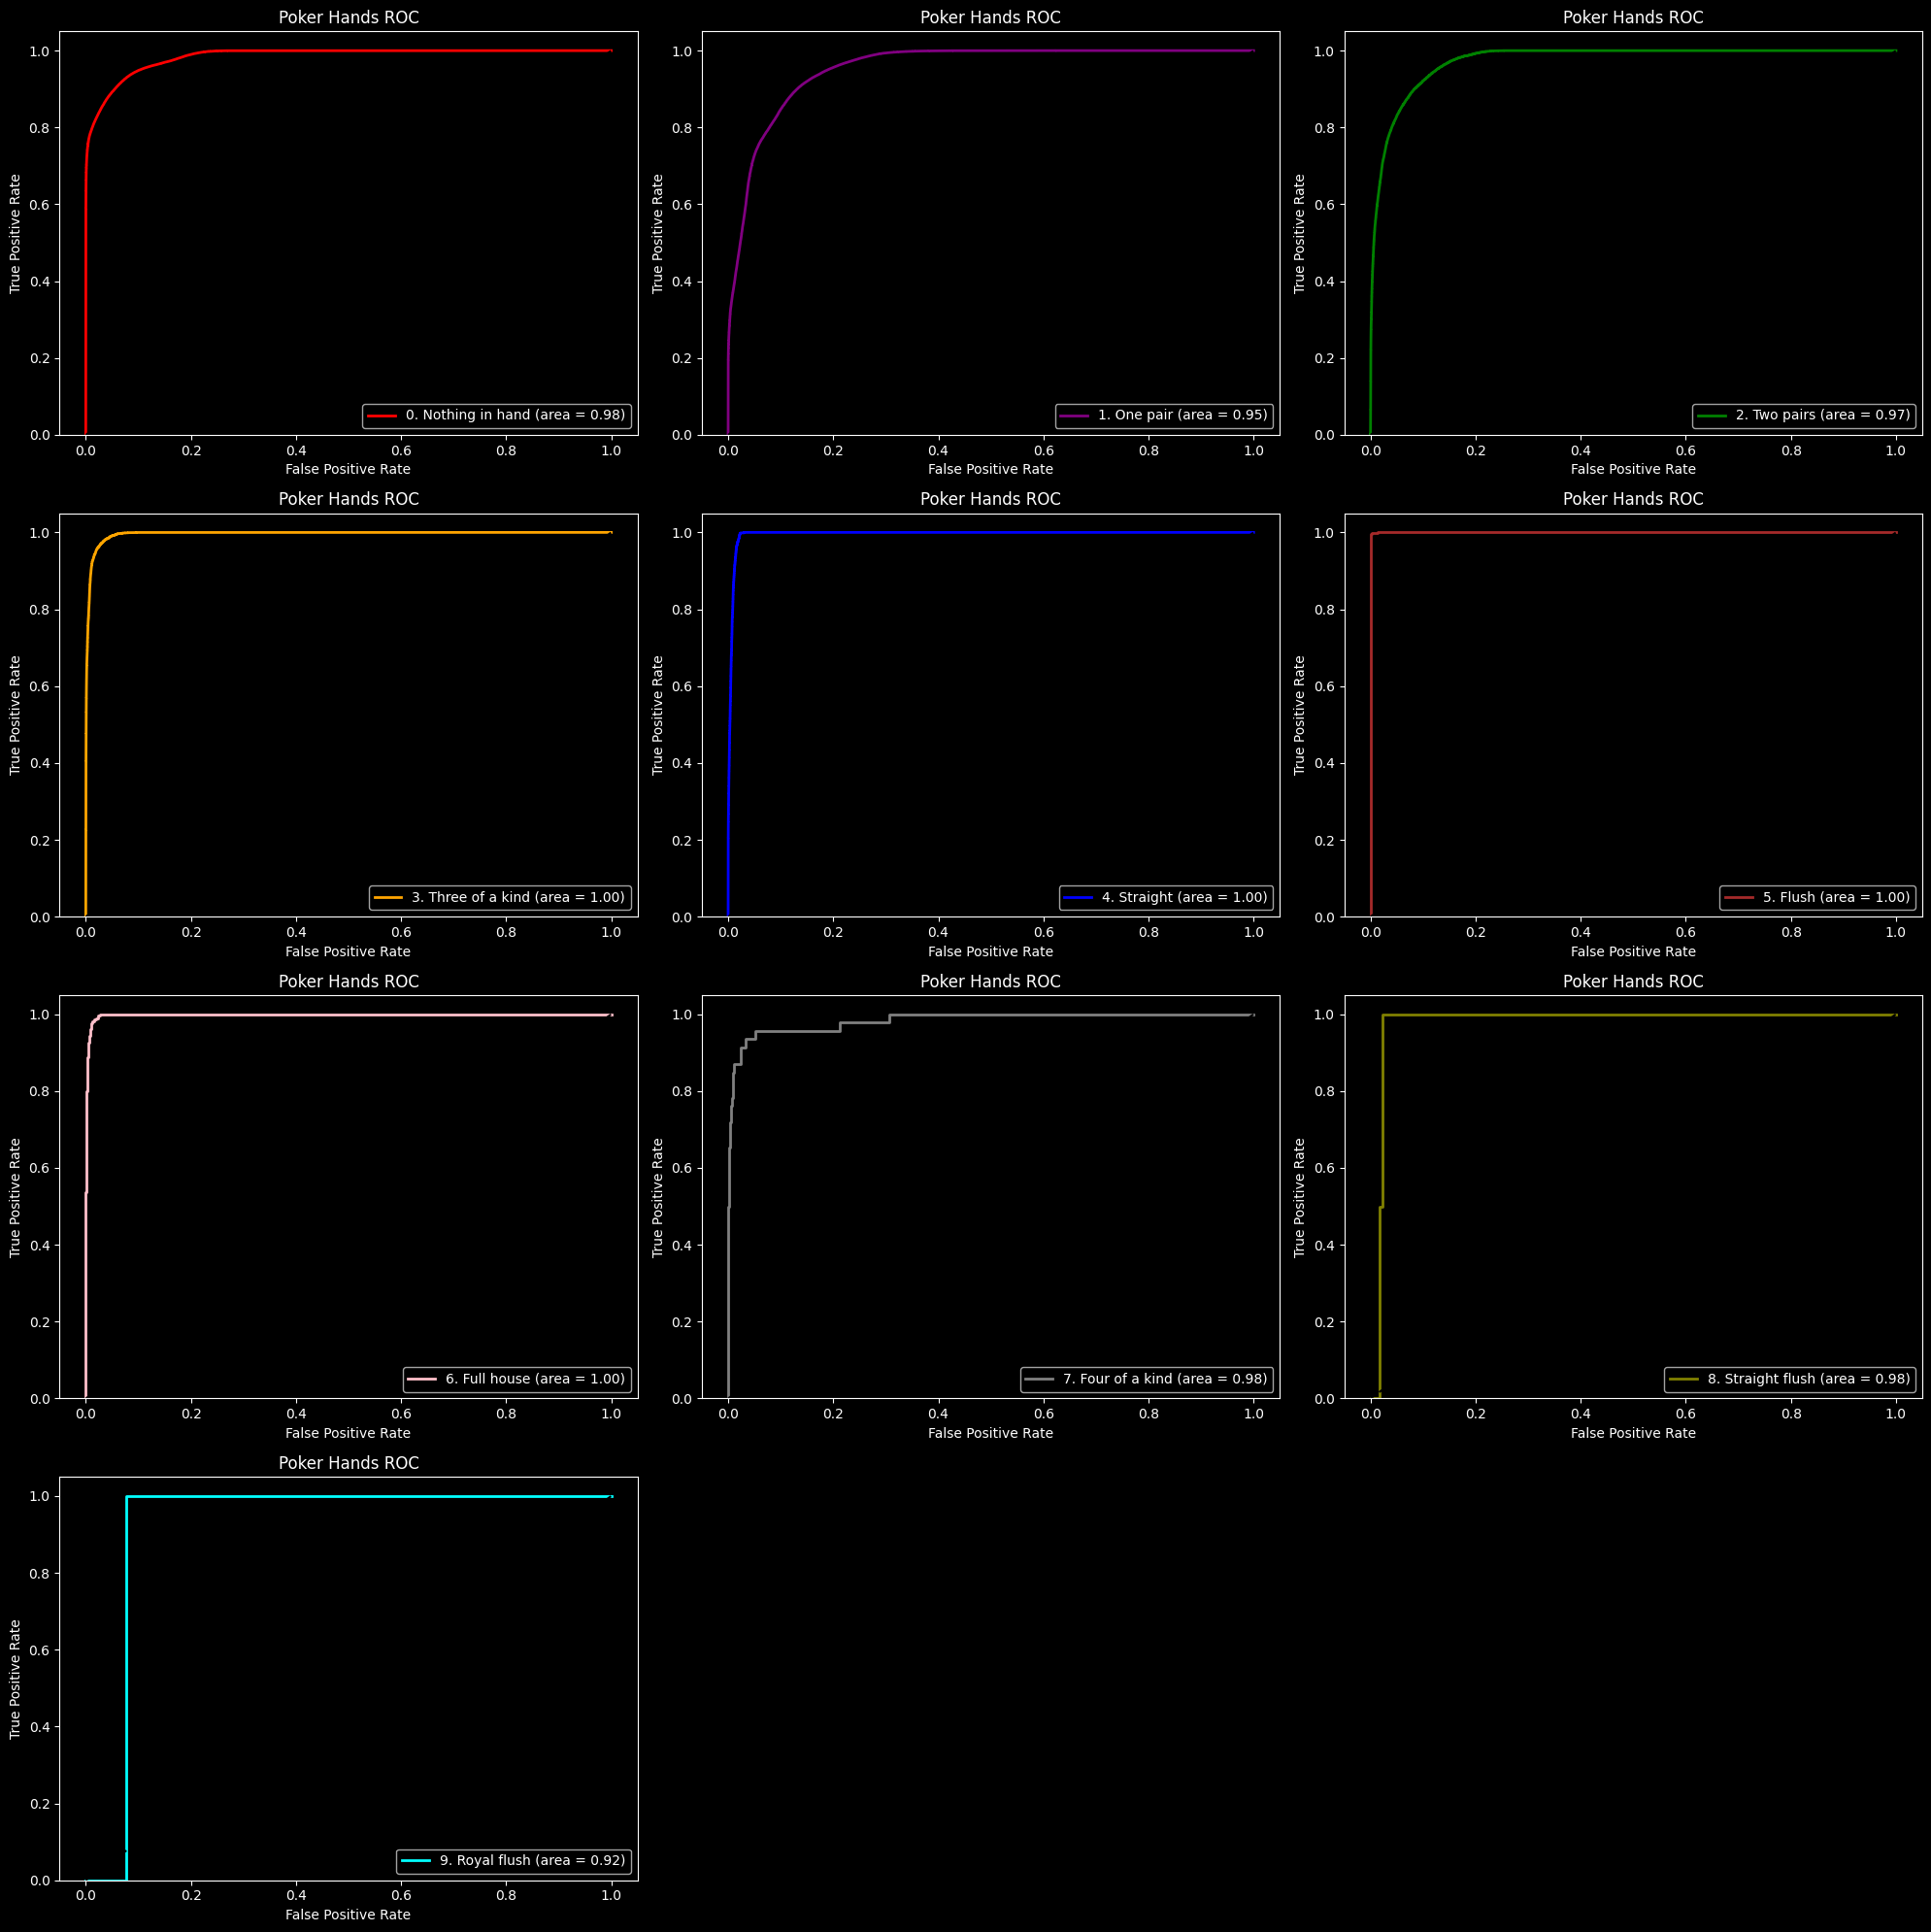

              precision    recall  f1-score   support

           0    0.87475   0.96614   0.91818    100242
           1    0.85410   0.83961   0.84679     84500
           2    0.89867   0.28402   0.43163      9524
           3    0.89949   0.62074   0.73456      4224
           4    0.96809   0.11712   0.20896       777
           5    0.98788   0.40852   0.57801       399
           6    1.00000   0.09474   0.17308       285
           7    1.00000   0.17391   0.29630        46
           8    1.00000   0.00000   0.00000         2
           9    1.00000   0.00000   0.00000         1

    accuracy                        0.86706    200000
   macro avg    0.94830   0.35048   0.41875    200000
weighted avg    0.86849   0.86706   0.85632    200000



In [ ]:
roc_plot(y_test, y_prob)
print(classification_report(y_test, y_pred, digits=5, zero_division=1))